In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from numpy import linalg as LA

import math
from scipy.integrate import quad

Spin boson model solution (based on Gernot's Example: https://www1.itp.tu-berlin.de/schaller/download/TOQT.pdf)

$ H_S= \frac{\omega}{2} \sigma_z + \frac{\Delta}{2} \sigma_x $

$ H_B= \sum_{k} \omega_k a_k ^{\dagger} a_k $

$ H_I= \sigma_z \otimes \sum t_{k}\left(a_{k}+a_{k}^{\dagger}\right)$

Exact solution:  pure-dephasing limit ($\Delta=0$)

$ H_S= \frac{\omega}{2} \sigma_z  $

$ H_B= \sum_{k} \omega_k a_k ^{\dagger} a_k $

$ H_I= \sigma_z \otimes \sum t_{k}\left(a_{k}+a_{k}^{\dagger}\right)$ 

The populatios remain unafected since $H_I$ conmustes with $H_S$, but the coherenes decay accroding to(in the interaction picture) : 

$\rho_{01}(t)=\exp \left\{-\frac{4}{\pi} \int_{0}^{\infty} J^{(0)}(\omega) \frac{\sin ^{2}(\omega t / 2)}{\omega^{2}} \operatorname{coth}\left(\frac{\beta \omega}{2}\right) d \omega\right\} \rho_{01}^{0}$


We will use this example for spectral densury 


$J^{(0)}(\omega)=2 \pi \sum_{k}\left|t_{k}\right|^{2} \delta\left(\omega-\omega_{k}\right)=\Gamma \frac{\omega \delta^{7}}{\left[(\omega-\epsilon)^{2}+\delta^{2}\right]^{2}\left[(\omega+\epsilon)^{2}+\delta^{2}\right]^{2}}$

with this paremeters:

$\mathbf{\Gamma} \beta=10000, \delta \beta=\mathbf{1}, \boldsymbol{\epsilon} \beta=2, \omega \beta=1$

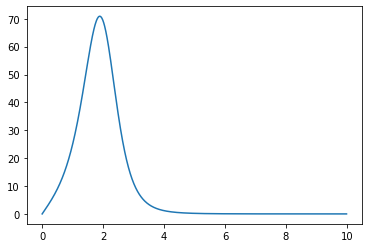

In [2]:
beta=1.0
Gamma= 10000.0/beta
delta= 1.0/beta
epsilon = 2.0 /beta 
omega=1.0/beta

rho_01_init=0.5

def J(w):
    return Gamma * ((w * delta**7) /(((w-epsilon)**2+delta**2)**2 * ((w+epsilon)**2+delta**2)**2 ))

#print (J(0.0))
vecfunc = np.vectorize(J)
w = np.arange(0.0, 10.0, 0.01)
T = vecfunc(w)
plt.plot (w, T)
plt.show()

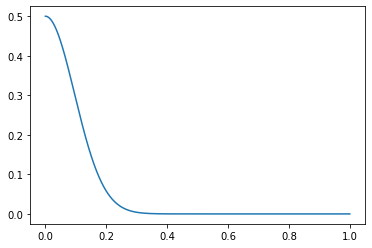

In [3]:
def integrand(w, t):
    return J(w)* (np.sin(w*t/2))**2 / (w**2)  / np.tanh (beta*w /2)


def expint(t):
    return quad(integrand, 0, np.inf, args=(t))[0]


def rho_01(t):
    return np.exp(-4.0/np.pi * expint(t)) * rho_01_init

vecfunc = np.vectorize(rho_01)
t1 = np.arange(0.0, 1.0, 0.001)
T1 = vecfunc(t1)
plt.plot (t1, T1)
plt.show()

Now we apply the reaccion coodinate mapping :

$  H_0= \frac{\omega}{2} \sigma_z +  \Omega_0 b ^{\dagger} b +g \sigma_z  \left( b + b ^{\dagger} \right) + \frac{g^2}{\Omega} \sigma_z^2 + \Omega \Delta_{RC} \left( b + b ^{\dagger} \right)^2$

$   H_B= \sum_{k} \Omega_k b_k ^{\dagger} b_k $

$   H_I= \left( b + b ^{\dagger} \right) \sum_k h_k \left( b_k + b_k ^{\dagger} \right)$

where the energy of the RC and the coupling strength become:

$\Omega_{0}^{2}=\frac{\left(\delta^{2}+\epsilon^{2}\right)^{2}}{5 \delta^{2}+\epsilon^{2}}, \quad g^{2}=\frac{\Gamma \delta^{4} \sqrt{5 \delta^{2}+\epsilon^{2}}}{64\left(\delta^{2}+\epsilon^{2}\right)^{2}}
$


The mapping transformation can be computed explicitly, where the transformed spectral density becomes ohmic:

$ J^{(1)}(\omega)=\frac{16 \omega \delta^{3} \sqrt{5 \delta^{2}+\epsilon^{2}}}{\omega^{4}+\omega^{2}\left(6 \delta^{2}-2 \epsilon^{2}\right)+\left(5 \delta^{2}+\epsilon^{2}\right)^{2}} $


And the renormalization energy as $\Delta_{RC}$: 

$\Omega_{0} \cdot \Delta_{RC} \equiv \sum_{k} \frac{h_{k}^{2}}{\Omega_{k}}=\frac{1}{2 \pi} \int_{0}^{\infty} \frac{J^{(1)}(\omega)}{\omega} d \omega$



1.6666666666666667


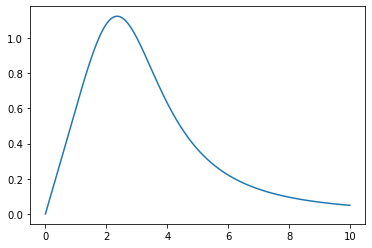

1.6666666666666667 4.330127018922194 0.2


In [4]:
##We build the supersystem Hamiltonian with N_RC number of modes for the RC

N_RC = 50 # number of basis states to consider
b = destroy(N_RC)

Omega_Rc=np.sqrt( (delta**2+ epsilon**2 )**2/(5*delta**2+ epsilon**2))
g=np.sqrt( (Gamma*delta**4*np.sqrt(5*delta**2+ epsilon**2))/(64*(delta**2+epsilon**2)**2)  )
print(Omega_Rc)

def J_1(w):
    return (16*w*delta**3*np.sqrt(5*delta**2+ epsilon**2))/(w**4+w**2*(6*delta**2-2*epsilon**2)+ (5*delta**2+epsilon**2)**2)

vecfunc = np.vectorize(J_1)
w = np.arange(0.0, 10.0, 0.01)
T = vecfunc(w)
plt.plot (w, T)
plt.show()

def integrand(w):
    return  J_1(w)/w

Delta_Rc = (1/(2*np.pi*Omega_Rc))* quad(integrand, 0, np.inf)[0]

print(Omega_Rc,g,Delta_Rc)

H0= omega/2 *tensor(sigmaz(), identity(N_RC) )  + Omega_Rc *tensor(identity(2) , b.dag() * b )  + g* tensor(sigmaz(),  b.dag() + b ) + Omega_Rc*Delta_Rc *tensor(identity(2) , (b.dag() + b)*(b.dag() + b) )  

In order to aplly the master equation we need to preapre the initial state as: 

$\rho_{0}=\rho_{S}^{0} \otimes \frac{e^{-\beta \Omega\left[b^{\dagger} b+\Delta_{Rc}\left(b+b^{\dagger}\right)^{2}\right]}}{Z_{R C}}$

In [5]:
##Rc inicial state Thermal  
H1 = b.dag() * b
H2 = Delta_Rc*(b.dag()+ b)*(b.dag()+ b)  ##Auxliar Hamiltonians
H_Rc= -beta*Omega_Rc*(H1+H2)
Exp= H_Rc.expm()
Z_Rc=Exp.tr()
rho_Rc_init=Exp/Z_Rc

#print(rho_Rc_init)

#Sistem inital state
psi0 = (1/np.sqrt(2.)) * (basis(2, 0) + basis(2, 1) )
#psi0 =  basis(2, 0) 

##Spin Inicial state 
rho_Spin= psi0*psi0.dag()
#print(rho_Spin)

###Tensor producto of the initial state
rho_init=tensor(rho_Spin,rho_Rc_init) 

print(rho_init.ptrace(0))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]


The evolutions is given by the master equation (in the interaction picture):

$\dot{\boldsymbol{\rho}}_{0}(t)=\gamma' \left(b \boldsymbol{\rho}_{0}(t) b^{\dagger}-\frac{1}{2}\left\{b^{\dagger} b, \boldsymbol{\rho}_{0}(t)\right\}\right)+\bar{\gamma}' \left(b^{\dagger} \boldsymbol{\rho}_{0}(t) b-\frac{1}{2}\left\{b b^{\dagger}, \boldsymbol{\rho}_{0}(t)\right\}\right)-\mathrm{i}\left[\frac{\sigma}{2} b^{\dagger} b+\frac{\bar{\sigma}}{2} b b^{\dagger}, \boldsymbol{\rho}_{0}(t)\right]$


where $\gamma'=J(\Omega)\left[1+n_{B}(\Omega)\right]$ , $ \bar{\gamma}' = J(\Omega) n_{B}(\Omega)$ and $n_{B}(\omega)=\left[e^{\beta \omega}-1\right]^{-1}$

and 
$\sigma =\sigma(\Omega)=\frac{\mathrm{i}}{\pi} \mathcal{P} \int_{-\infty}^{+\infty} \frac{\gamma(\Omega')}{\Omega-\Omega'} d \Omega'$

In [6]:
def nb(w):
    return 1/(np.exp(beta*w)-1)

def gamma_prime(w):
     return J_1(w)*(1+nb(w))

gamma_prime_n= J_1(Omega_Rc)*(1+nb(Omega_Rc))
gamma_bar_prime_n= J_1(Omega_Rc)*nb(Omega_Rc)

print(gamma_prime_n,gamma_bar_prime_n , gamma_prime(Omega_Rc))

1.186002113574108 0.22400686416793208 1.186002113574108


In [63]:
#from sympy import oo
#from sympy.integrals.integrals import Integral
#from sympy.abc import x

#Calculate the lamb Shift 
#Integral(gamma_prime(x)/(Omega_Rc-x), (x, -oo, oo)).principal_value()

In [7]:
L1=tensor(identity(2) ,  b )
L2=tensor(identity(2) , b.dag()  )
L=[np.sqrt(gamma_prime_n) * L1, np.sqrt(gamma_bar_prime_n)*L2 ]


We find the the coherences as:

$\left|\rho_{01}\right|=\mid \frac{1}{2} \operatorname{Tr}\left\{\left(\sigma^{x}+\mathrm{i} \sigma^{y}\right) \rho(t)\right\}$

In [8]:
t0 = 0.0
tf = 1.0
time_steps = 200


## Time range
t = np.linspace(0, tf, time_steps)

result = mesolve(H0, rho_init, t, L)


states_IP=result.states


trace=[0 for i in range(len(states_IP))]
for i in range(len(states_IP)):
    trace[i]=  states_IP[i].ptrace(0)

print(trace[0])    


p01=[0 for i in range(len(states_IP))]
for i in range(len(states_IP)):
    p01[i]=abs(expect(0.5*(sigmax()+1j*sigmay()),trace[i]))

#print(p01)  

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]


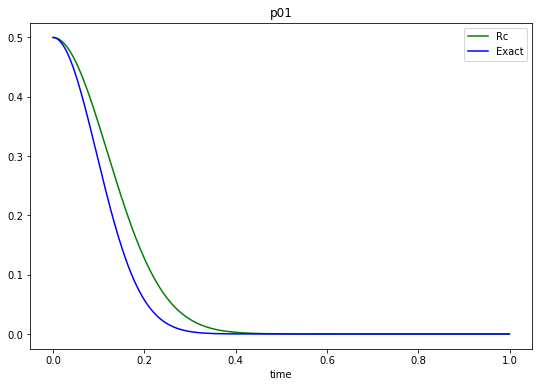

In [16]:
plt.figure(figsize=(9,6))
plt.title("p01")
plt.rcParams['figure.figsize'] = [15,5]
plt.plot(t,p01,"-",label='Rc', color = "g")
plt.plot (t1, T1,"-",label='Exact', color = "b")
#plt.plot(tlist, result.expect[0])
plt.xlabel("time")
plt.legend()
plt.show()